In [2]:
what_we_are_covering =  {1: "data(prepare and load)",
                         2: "build model",
                         3: "fitting the model to data (training)",
                         4: "making predictions and evaluating a model (inference)",
                         5: "saving and loading a model",
                         6: "putting it all together"}

what_we_are_covering

{1: 'data(prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [3]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

## 1. Data (preparing and loading)

Data can be almost anything in ML and DL
* Excel spreadsheet
* Images of any kind
* Videos(Youtube, Twitch, Tiktok etc)
* Audio, like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numerical representation.
2. Build and train a model to predict patterns in that data.

Let's showcase this by creating a *known* data using linear regression formula

We'll use linear regression formula to make a straight line with *known* **parameters**

Y = a + bX

b = weight

a = bias

In [4]:
# Create *known* parameters
weight = 0.7
bias = 0.3
# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = bias + weight * X

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets(one of the most important concept in machine learning in general)

Let's create a training and test set with our data

In [6]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

How might better visualize our data?

Follow a simple motto:

"Visualize, Visualize, Visualize"

In [7]:
def plot_prediction(train_data = X_train,
                    train_labels = y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):
  plt.figure(figsize = (10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, color = "blue", s = 4, label = "Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, color = "green", s = 4, label = "Testing data")

  # Are there predictions
  if predictions is not None:
    # Plot the prediction if they exist
    plt.scatter(test_data, predictions, color = "red", s = 4, label = "Predictions")

  # Show the legend
  plt.legend(prop = {"size": 14 })

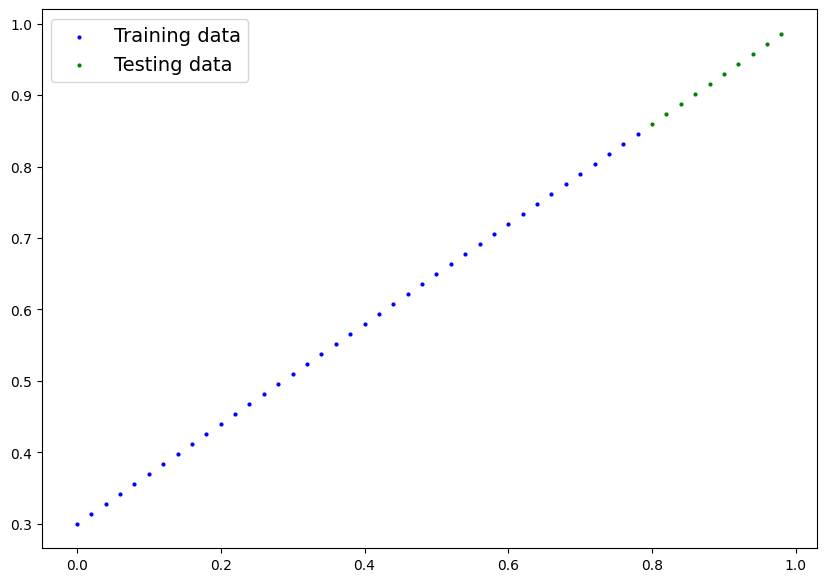

In [8]:
plot_prediction()

## Building our first PyTorch model

What our model does:
* Start with random values(weight and bias)
* Loot at training data and adjust the random values to better represent (or get close to) the ideal values (the weight and bias values we used to create the data)

How does it do so?

Through two main algorithms
1. Gradient decent
2. Backpropagation

In [9]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module): # Almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad = True, # it is True by default
                                           dtype = torch.float)) # PyTorch likes to work with float32 dtype

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad = True,
                                         dtype = torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # This is the linear regression formula

### PyTrorch model building essentials

* torch.nn - contains all of the buildings for computational graphs(a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward(), All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

### Checking the contents of our PyTorch model

Let's see what's inside our class...

We can check our model parameters or what's inside out model using `.parameters`

In [10]:
# Create a random seed
torch.manual_seed(42)

# Create an instanec off the model (this is an subclass of nn.Module)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the forward() method

In [12]:
# Make predictions with model
with torch.inference_mode():
  y_preds= model_0(X_test)


# We can also use torch.no_grad(), however, inference mode is preferred
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

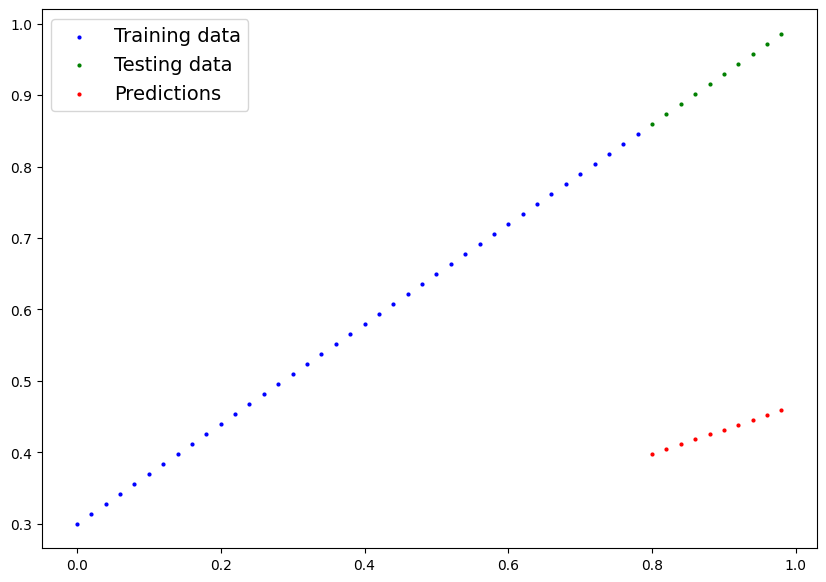

In [13]:
plot_prediction(predictions = y_preds)

## 3. Train a model

The whole idea of training is for a model to move from some *unknown* parameters (these maybe random) to some *known* parameters

Or in other words, from a poor representation of the data to a better representation of the data

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters(e.g, weight & bias in our case) to improve the loss function

Inside the optimizer you'll often have to set two parameters
* `params` - the model parameters you'd like to optimize, for exapmle `params = model_0.parameters()`
* lr(learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters will each step(a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch we need
* A training loop
* A testing loop

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
rm -rf __pycache__ torch.py torch.pyc

In [17]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer(stocastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01) # Learning rate = possibly the most important hyperparameter you can set

In [18]:
loss_fn

L1Loss()

**Q:** Which loss function and optimizer should i use?

**A:** This will be problem specific. But with experienve, you'll get an idea of what works and what does not with your particular problem.

For example, for a regression problem(like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (Binary Cross Entropy Loss)

### Building a training loop and Testing loop in PyTorch

A couple of things we need in a training loop
0. Loop through the data...
1. Forward pass (This involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation.
2. Calculate the loss (compare forward pass prediction to ground truth labels)
3. Optimize zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss(**backpropagation**)
5. Optimize step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [19]:
torch.manual_seed(42)

# An epoch is one loop through the data... (This is a hyperparameter since we set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training loop
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parametes that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  #print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optomizer changes will accumulate throught the loop so... we have to zero them above in step 3 for the next iteration if the loop

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluating/testing(dropout/batch norm layers)
  with torch.inference_mode(): # Turns off gradient descent and other things that we do not need for testing our model
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    # Print our model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [20]:
import numpy as np

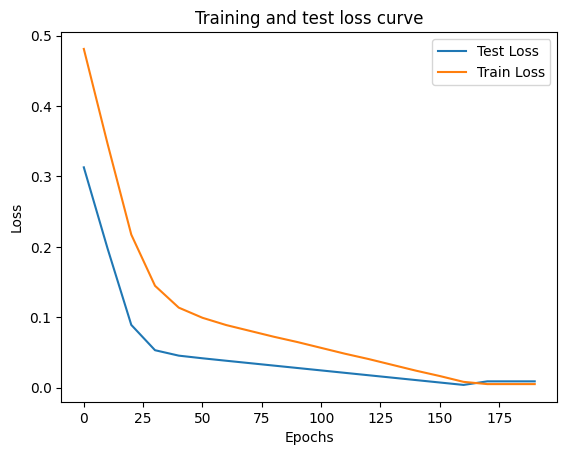

In [21]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Test Loss")
plt.plot(epoch_count, test_loss_values, label = "Train Loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [22]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

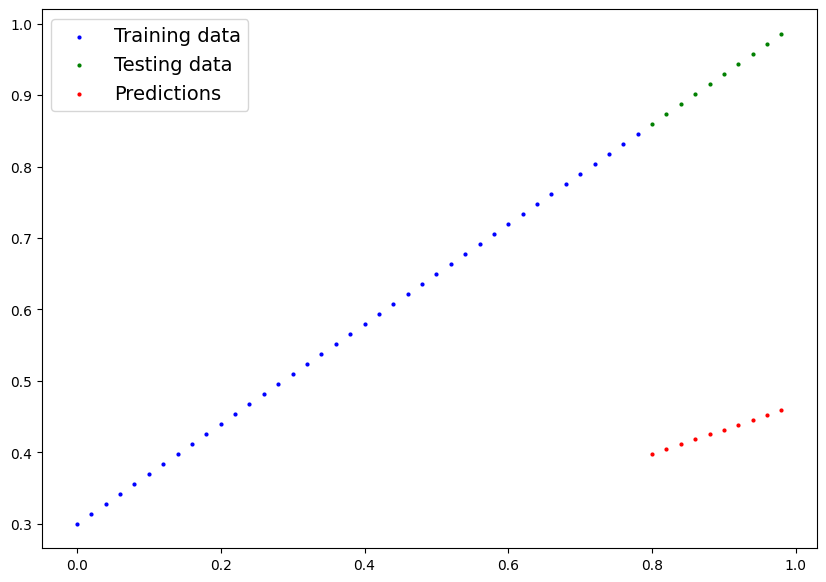

In [23]:
plot_prediction(predictions = y_preds)

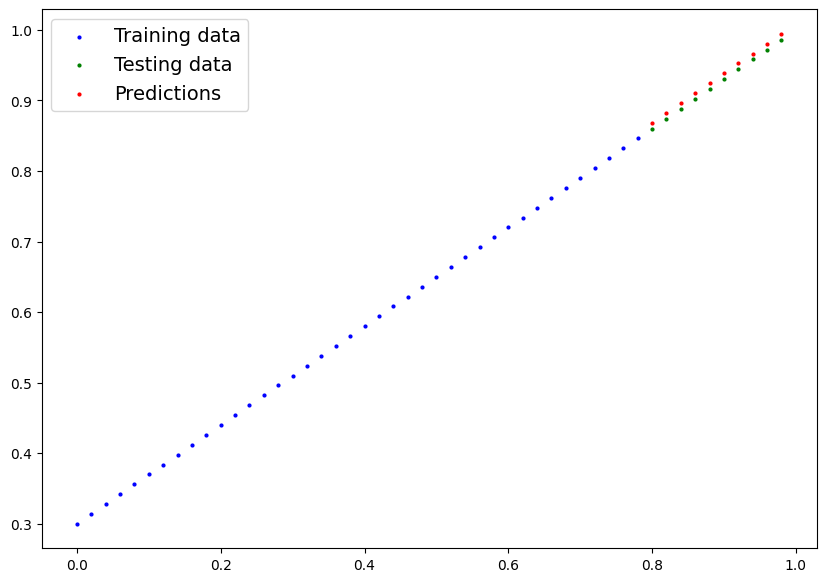

In [24]:
plot_prediction(predictions = y_preds_new)

## 6.2 Building a PyTorch Linear Model

In [25]:
# Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Create device agnostic code

If GPU is available then the code will use it else it will use CPU

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [27]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [28]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.2 Training Code

For training code:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [29]:
# Setup the loss function
loss_fn = nn.L1Loss()

# Setup our optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [31]:
# Let's write a training loop
torch.manual_seed(42)

# Put our data to cuda as the model is also on GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 200

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimize the zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out to visualize
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss}| Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567| Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537| Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397| Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355| Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564| Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914| Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752| Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156| Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334| Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502| Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401| Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385| Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314| Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314| Test Loss: 0.013801801018416882
Epoch: 140

In [33]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [34]:
weight, bias

(0.7, 0.3)